In [ ]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
from tensorflow.keras.layers import Conv2D,Dense,MaxPooling2D,Flatten,BatchNormalization,Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import preprocess_input
import matplotlib.pyplot as plt
import cv2 as cv
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix,classification_report
from keras.utils import to_categorical

import os



In [ ]:
train_path_str = '/content/Dataset/Data/train'
val_path_str = '/content/Dataset/Data/valid'
test_path_str = '/content/Dataset/Data/test'

In [ ]:
test_classes = os.listdir(test_path_str)

In [ ]:
input_shape = (224,224,3)
num_classes = 4

trainGenertor = ImageDataGenerator(
    preprocessing_function = preprocess_input,
    rotation_range = 10,
    width_shift_range = 0.3,
    height_shift_range = 0.3,
    shear_range = 0.2,
    zoom_range = 0.1,
    horizontal_flip = True,
    vertical_flip = True,
    dtype = 'float32'
)
valGenertor = ImageDataGenerator(
    preprocessing_function = preprocess_input,
    dtype = 'float32'
)

testGenertor = ImageDataGenerator(
    preprocessing_function = preprocess_input,
    dtype = 'float32'
)


In [ ]:
train_data = trainGenertor.flow_from_directory(
    train_path_str,
    target_size = (224,224),
    batch_size = 16,
    class_mode = 'categorical'
)

val_data = valGenertor.flow_from_directory(
    val_path_str,
    target_size = (224,224),
    batch_size = 16,
    class_mode = 'categorical'
)

test_data = testGenertor.flow_from_directory(
    test_path_str,
    target_size = (224,224),
    batch_size = 16,
    class_mode = 'categorical',
    shuffle = False
)

Found 613 images belonging to 4 classes.
Found 72 images belonging to 4 classes.
Found 315 images belonging to 4 classes.


In [ ]:
VGG16_model = VGG16(
    include_top = False,
    weights="imagenet",
    input_shape = input_shape
)
for layer in VGG16_model.layers :
  layer.trainable = False

In [ ]:
from keras.src.metrics.confusion_metrics import activations
model = Sequential()
model.add(VGG16_model)
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2)))
model.add(Flatten())
model.add(Dense(1024,activation = 'relu'))
model.add(Dropout(0.3))
model.add(Dense(512,activation = 'relu'))
model.add(Dropout(0.3))
model.add(Dense(256,activation = 'relu'))
model.add(Dense(128,activation = 'relu'))
model.add(Dense(num_classes,activation = 'softmax'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 batch_normalization_2 (Bat  (None, 7, 7, 512)         2048      
 chNormalization)                                                
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 3, 3, 512)         0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 4608)              0         
                                                                 
 dense_8 (Dense)             (None, 1024)              4719616   
                                                                 
 dropout_6 (Dropout)         (None, 1024)             

In [ ]:
model.compile(
    optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy']
)
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=5),
    tf.keras.callbacks.ModelCheckpoint('model.h5',save_best_only=True),
    tf.keras.callbacks.TensorBoard(log_dir='logs')
]

In [ ]:
results = model.fit(train_data,validation_data=val_data,epochs=100,verbose = 1)

Epoch 1/100
39/39 [==============================] - 17s 308ms/step - loss: 1.7665 - accuracy: 0.4323 - val_loss: 3.2961 - val_accuracy: 0.4861
Epoch 2/100
39/39 [==============================] - 12s 308ms/step - loss: 1.2291 - accuracy: 0.4763 - val_loss: 0.9439 - val_accuracy: 0.5139
Epoch 3/100
39/39 [==============================] - 12s 307ms/step - loss: 1.0384 - accuracy: 0.5383 - val_loss: 0.9646 - val_accuracy: 0.5417
Epoch 4/100
39/39 [==============================] - 12s 308ms/step - loss: 0.9680 - accuracy: 0.5432 - val_loss: 0.8980 - val_accuracy: 0.5694
Epoch 5/100
39/39 [==============================] - 12s 310ms/step - loss: 0.9466 - accuracy: 0.5498 - val_loss: 1.0027 - val_accuracy: 0.4861
Epoch 6/100
39/39 [==============================] - 12s 303ms/step - loss: 0.8528 - accuracy: 0.6117 - val_loss: 0.8435 - val_accuracy: 0.5556
Epoch 7/100
39/39 [==============================] - 11s 277ms/step - loss: 0.8674 - accuracy: 0.6330 - val_loss: 0.9420 - val_accuracy:

In [ ]:
loss, acc = model.evaluate(test_data,verbose = 1)

20/20 [==============================] - 5s 229ms/step - loss: 0.3263 - accuracy: 0.9048


In [ ]:
import seaborn as sns
predictions_prob = model.predict(test_data)
predictions = np.argmax(predictions_prob , axis = 1)
true_label = test_data.classes
report = classification_report(true_label,predictions)
print(report)


20/20 [==============================] - 2s 103ms/step
              precision    recall  f1-score   support

           0       0.88      0.90      0.89       120
           1       0.93      0.84      0.89        51
           2       1.00      0.94      0.97        54
           3       0.87      0.92      0.90        90

    accuracy                           0.90       315
   macro avg       0.92      0.90      0.91       315
weighted avg       0.91      0.90      0.91       315



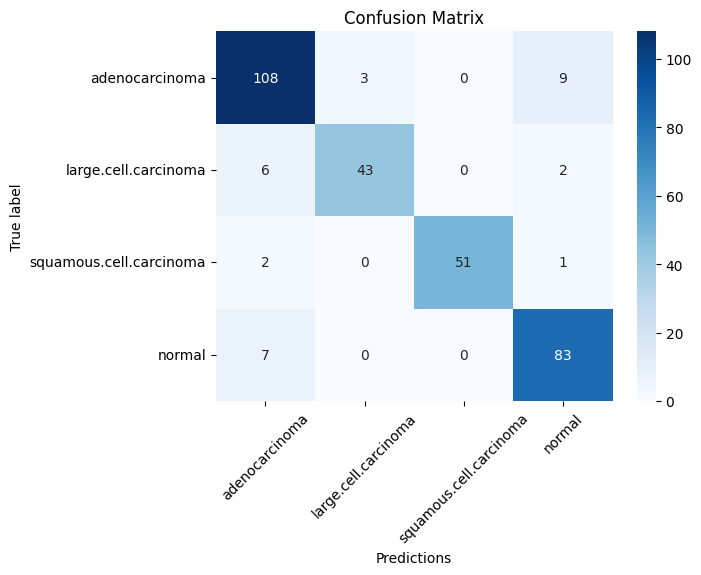

In [ ]:
conf_mat = confusion_matrix(true_label,predictions)
sns.heatmap(conf_mat ,fmt='g',annot = True , cmap='Blues' , xticklabels=test_classes , yticklabels = test_classes,)
plt.xlabel('Predictions')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.xticks(rotation = 45)
plt.show()

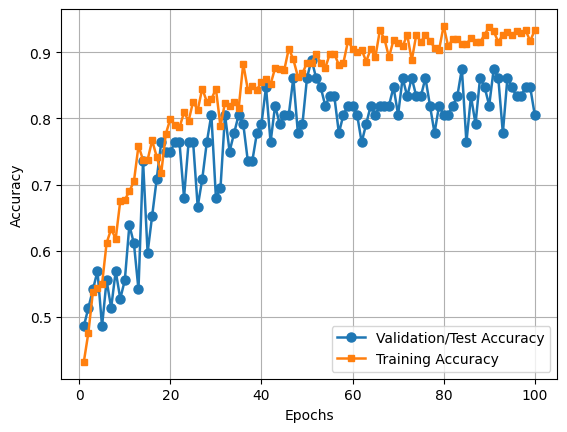

In [ ]:
res = results.history
train_acc = res['accuracy']
val_accuracy = res['val_accuracy']
epochs = range(1, len(train_acc) + 1)

line1 = plt.plot(epochs, val_accuracy, label = 'Validation/Test Accuracy')
line2 = plt.plot(epochs, train_acc, label = 'Training Accuracy')

plt.setp(line1, linewidth = 1.8, marker = 'o', markersize = 6.5)
plt.setp(line2, linewidth = 1.8, marker = 's', markersize = 5)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()
plt.show()

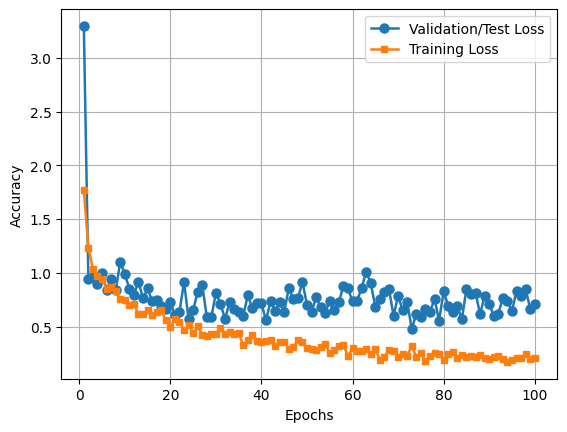

In [ ]:
res = results.history
train_loss = res['loss']
val_loss = res['val_loss']
epochs = range(1, len(train_loss) + 1)

line1 = plt.plot(epochs, val_loss, label = 'Validation/Test Loss')
line2 = plt.plot(epochs, train_loss, label = 'Training Loss')

plt.setp(line1, linewidth = 1.8, marker = 'o', markersize = 6.5)
plt.setp(line2, linewidth = 1.8, marker = 's', markersize = 5)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()
plt.show()